In [46]:

# This main objective for this code is make a feed foward Neural Network (ANN) and train 
# it using the TPU dataset

# We want to train a model that can learn how the cp values on a building will change with 
# changing incident angles. This means that the shape of building will remain constant for 
# a given model along with the incoming velocity profile curve.

# The model will have the following properties: predict the cp value at a given point a 
# building for a given incidence wind angle and a given dimensional configuration.
# After training the model will take the location (x,y,z) and incident wind angle (a)
# as inputs and produce the mean cp as output.

# necessary imports
import numpy as np
import pandas as pd

# the TPU dataset available on the website is in the .mat format. This import allowes
# to read .mat files in python.
from pymatreader import read_mat

#import necessary to look for files in the working directory
import os.path

# for graphs and plots
import matplotlib.pyplot as plt


In [47]:
# defining breadth(b), height (h) and velocity profile(p) these values will remain the same
# throughout this code 
b=1
h=1
p=4

# *****TPU FILE NOMENCLATURE**** : It is important to understand the nomenclature behind the 
# files downloaded from the TPU website in order to understand the code.
# for Example : if the file name is 'T112_4_010_1.mat' it would mean the file corresponds to the 
# breadth:depth:height ratio of 1:1:2 with a velocity profile of 1/4 power law and
# an incident wind angle of 010 degrees tilted from the normal. Now that we fixed the building 
# configuration we can load one of the files to check the information inside.


# loading the datafile 
df = read_mat('T114_4_000_1.mat')

# since the datafile contains different types of information it generally contains several 
# variables. calling the "keys()" function shows the variables available in the .mat files.
df.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Building_breadth', 'Building_depth', 'Building_height', 'Location_of_measured_points', 'Readme', 'Sample_frequency', 'Sample_period', 'Wind_direction_angle', 'Wind_pressure_coefficients', 'Uh_AverageWindSpeed'])

In [48]:

# now that we know what variables are in the datafile we can start with merging all the variables
# in these files for the given configuration. the variable of interest for us is the 
# 'Wind_pressure_coefficients' variable.  

# defining an empty dataframe for use later. dtype has to be defined for empty
# dataframes
dataframe = pd.Series([],dtype=float)
    
# loop to merge all files of similar configuration

# looping strategy : the looping contains 3 nested loops m,n,k which correspond to the 
# 100s, 10s, and 1s, place for the incoming angle in the filename. since b,h,p are already defined 
# the resulting filename should look like this : 'T114_4_mnk_1.mat'. this will result in loading 
# different files based on the values of m,n and k.

 
# m is the 100s place in the angle. the TPU data set has angles varying from 0 to 150 degress with a 5 degree increment.
# this mean the 100s place value can vary only between 0 and 1 hence range is 2 
for m in range(2):
    
    # n is 10s place and can range from 0 to 9 hence range 10
    for n in range(10):

        # k is the 1s place and can only be either 0 or 5 hence the range 6 
        for k in range(6):
            
            # after the values set in the loop '.format' allows us to place variable in a string. each {} is a variable.  
            filename = "T{}1{}_{}_{}{}{}_1.mat".format(b,h,p,m,n,k)

            # this ensures the loop proceeds for only existing filenames. The '.isfile' checks for existance of the file in the working directory  
            if os.path.isfile(filename) == True:
                df = read_mat(filename)

                # assigning variables to keys available in the datafile.
                avgspeed= df['Uh_AverageWindSpeed']
                # the position of points is an important variable. Transpose is done for later.
                # the position variable has 4 columns. "0,1,2,3" corresponding to x,y,pointnum and facenum
                position = pd.DataFrame(df['Location_of_measured_points']).transpose()
                breadth = df['Building_breadth']
                depth = df['Building_depth']
                height = df['Building_height']

                # the TPU dataset position of pressure taps is presented in the following way. each point has a x,y coordinate 
                # along with the face number. faces 1,2,3,4 correspond to windward,right,leeward,left respectively. 
                # the x,y coordinates are the coordinates resulting after the model is "unwrapped" and the point of origin
                # being the bottom right corner of face1. please check 
                # http://www.wind.arch.t-kougei.ac.jp/info_center/windpressure/highrise/Test_Result/T114_4_channels.jpg for futher clarification.


                #changing the data from 2-D points and faces to 3-D points.

                # to achieve this add additional columns x,y,z to the position dataframe and generate x,y,z values
                # based on the x,y,face values using the below strategy.  

                position.columns = position.columns.map(str) # this ensures the column values are converted to strings 
                position['x']=0 # initializing x 
                position['y']=position['1'] # the y coordinate will be unchanged be in 2-d or 3-d to we just equate existing y to the new y
                position['z']=0 # initializing z


                for index, row in position.iterrows():  # iterrating through each row.T
                    
                    # now we create 4 "if" conditions correspond to 4 faces to convert 2d to 3d since y is the same only x and z
                    # values need to be changed.
                    if row['3'] == 1: 
                            # conversion for  face 1
                            position['x'][index]= row['0']
                    elif row['3'] == 2:
                            # conversion for  face 2
                            position['z'][index]= row['0']-breadth
                            position['x'][index]= breadth
                    elif row['3'] == 3:
                            # conversion for  face 3
                            position['z'][index]= depth
                            position['x'][index]= (breadth+breadth+depth)-row['0']
                    elif row['3'] == 4:
                            # conversion for  face 4
                            position['z'][index]= (breadth+breadth+depth+depth)-row['0']
                
                # dropping the position values and renaming the columns
                xyz = position.drop(['0','1','3'],axis=1)
                xyz.rename(columns={"2":"num"},inplace=True)

                #adding mean cp data
                cp  = pd.DataFrame(df['Wind_pressure_coefficients'])
                # .mean() creates a mean of the entire column
                meancp = cp.mean()
                # merging the cp data to the position data
                dat = pd.concat([xyz,meancp],axis=1)

                #adding the corresponding angle column. the angle will be same for a given datafile hence 
                # we create a column with the same angle value with length of the dataframe.
                a = m*100+n*10+k
                angle = pd.Series([a]*(len(dat)))

                #adding angle value
                meandat = pd.concat([dat,angle],axis=1,ignore_index=True)

                #merging old and new dataframes for each loop.
                dataframe = pd.concat([dataframe,meandat],axis=0)

C:\Users\shiva\AppData\Local\Temp\ipykernel_956\2425159201.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position['x'][index]= row['0']
C:\Users\shiva\AppData\Local\Temp\ipykernel_956\2425159201.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position['z'][index]= row['0']-breadth
C:\Users\shiva\AppData\Local\Temp\ipykernel_956\2425159201.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position['x'][index]= row['0']
C:

In [49]:
xyz # check the xyz conversion strategy

,num,x,y,z
0,1.0,0.01,0.09,0.00
1,2.0,0.03,0.09,0.00
2,3.0,0.05,0.09,0.00
3,4.0,0.07,0.09,0.00
4,5.0,0.09,0.09,0.00
...,...,...,...,...
95,96.0,0.00,0.01,0.09
96,97.0,0.00,0.01,0.07
97,98.0,0.00,0.01,0.05
98,99.0,0.00,0.01,0.03


In [50]:
dataframe = dataframe.reset_index()
dataframe #final dataframe check. last 2 columns are (from the left) angle and mean cp 

,index,0,1,2,3,4,5
0,0,1.0,0.01,0.09,0.00,0.511732,0.0
1,1,2.0,0.03,0.09,0.00,0.581686,0.0
2,2,3.0,0.05,0.09,0.00,0.570187,0.0
3,3,4.0,0.07,0.09,0.00,0.548711,0.0
4,4,5.0,0.09,0.09,0.00,0.449761,0.0
...,...,...,...,...,...,...,...
1095,95,96.0,0.00,0.01,0.09,-0.511537,50.0
1096,96,97.0,0.00,0.01,0.07,-0.553642,50.0
1097,97,98.0,0.00,0.01,0.05,-0.574825,50.0
1098,98,99.0,0.00,0.01,0.03,-0.542054,50.0


In [51]:
#preparing dataset for training
   
traindat = dataframe[[1,2,3,4,5]] # training data will only have x,y,z,meancp and angle
traindat # training data check

,1,2,3,4,5
0,0.01,0.09,0.00,0.511732,0.0
1,0.03,0.09,0.00,0.581686,0.0
2,0.05,0.09,0.00,0.570187,0.0
3,0.07,0.09,0.00,0.548711,0.0
4,0.09,0.09,0.00,0.449761,0.0
...,...,...,...,...,...
1095,0.00,0.01,0.09,-0.511537,50.0
1096,0.00,0.01,0.07,-0.553642,50.0
1097,0.00,0.01,0.05,-0.574825,50.0
1098,0.00,0.01,0.03,-0.542054,50.0


In [52]:
# imports for random test-train split and error metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


X = traindat[[1,2,3,5]] # defining inputs
y = traindat[4]         # defububg outputs
    
#splitting dataset into test and train sets with random sampling this is a 80-20 split 
    
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [53]:
X_test #checking test dataset after random sampling

,1,2,3,5
328,0.10,0.07,0.07,15.0
688,0.10,0.01,0.07,30.0
413,0.03,0.09,0.10,20.0
788,0.10,0.01,0.07,35.0
244,0.09,0.05,0.00,10.0
...,...,...,...,...
319,0.00,0.09,0.01,15.0
979,0.00,0.03,0.01,45.0
919,0.00,0.09,0.01,45.0
989,0.10,0.01,0.09,45.0


In [54]:
# creating the NN architecture

# we use the keras python package for constructing the NN.
from keras.models import Sequential
from keras.layers import Dense

# sequential is the call for a FeedForward NN.
model = Sequential()

# adding the first layer in 4 inputs and relu activation function
model.add(Dense(16, input_shape=(4,), activation='relu'))

# adding a hidden layer
model.add(Dense(16, activation='relu'))
# adding a hidden layer
model.add(Dense(16, activation='relu'))
# adding a hidden layer
model.add(Dense(16, activation='relu'))
# adding the output layer. 1 output and linear activation function
model.add(Dense(1,activation='linear'))


# defining the loss function and optimizer
model.compile(loss = 'mean_squared_error',optimizer='adam')

# training the model with the stopping criterion being the number of epochs
model.fit(X_train,y_train, epochs=1000, batch_size=32)

y_pred = model.predict(X_test)

nn_pred = model.predict(X)

# generating error metrics.
nn_r2 = r2_score(y_test, y_pred)
nn_mse = mean_squared_error(y_test, y_pred)

Epoch 1/1000
28/28 [==============================] - 1s 768us/step - loss: 0.3000
Epoch 2/1000
28/28 [==============================] - 0s 757us/step - loss: 0.2706
Epoch 3/1000
28/28 [==============================] - 0s 752us/step - loss: 0.2523
Epoch 4/1000
28/28 [==============================] - 0s 795us/step - loss: 0.2470
Epoch 5/1000
28/28 [==============================] - 0s 804us/step - loss: 0.2476
Epoch 6/1000
28/28 [==============================] - 0s 787us/step - loss: 0.2484
Epoch 7/1000
28/28 [==============================] - 0s 770us/step - loss: 0.2413
Epoch 8/1000
28/28 [==============================] - 0s 833us/step - loss: 0.2407
Epoch 9/1000
28/28 [==============================] - 0s 727us/step - loss: 0.2429
Epoch 10/1000
28/28 [==============================] - 0s 759us/step - loss: 0.2496
Epoch 11/1000
28/28 [==============================] - 0s 739us/step - loss: 0.2518
Epoch 12/1000
28/28 [==============================] - 0s 738us/step - loss: 0.2445
E

In [55]:
print(nn_r2 ,nn_mse) #checking the error metrics

0.933915304673379 0.016275058


In [56]:
# the training of the model is done and everything below is code for generating a graph to the compare
# the experimental values to the predicted values for the first 20 tap locations.
modelpred = model.predict(X)
graphdat = dataframe[[0,4]].copy()
pred_dat = np.transpose(modelpred)
flattened_array = pred_dat.flatten()

pred_ser = pd.Series(flattened_array)
graph = pd.concat([graphdat,pred_ser],axis=1,ignore_index = True)
graph # this is the dataframe showing the tap no. , true value and predicted value.


35/35 [==============================] - 0s 548us/step


,0,1,2
0,1.0,0.511732,0.482628
1,2.0,0.581686,0.586807
2,3.0,0.570187,0.590597
3,4.0,0.548711,0.555367
4,5.0,0.449761,0.421714
...,...,...,...
1095,96.0,-0.511537,-0.570336
1096,97.0,-0.553642,-0.535589
1097,98.0,-0.574825,-0.500844
1098,99.0,-0.542054,-0.466099


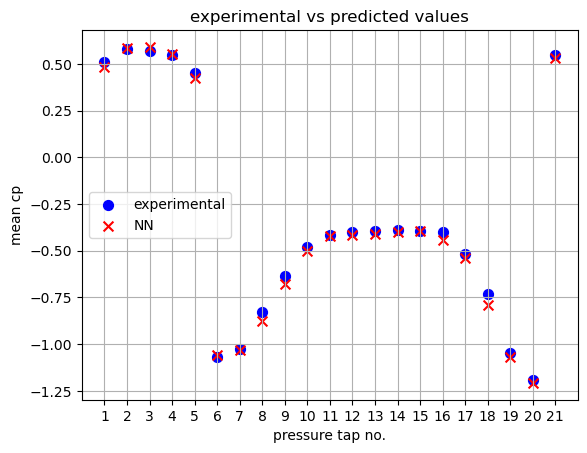

In [57]:

# plotting the graph 

tap = graph.loc[:20,0]
y1 = graph.loc[:20,1]
y2 = graph.loc[:20,2]

# plt.figure(figsize=(8, 6))  
plt.title('experimental vs predicted values') 

plt.scatter(tap, y1, label='experimental', color='blue', marker='o', s=50)

plt.scatter(tap, y2, label='NN', color='red', marker = 'x', s=50)

plt.grid()

plt.legend()

plt.xlabel('pressure tap no.')
plt.ylabel('mean cp')

custom_xticks = np.linspace(1,21,21)
plt.xticks(custom_xticks)
plt.show()

